# MFA

## Definition of the system

In [1]:
import flodym as fd

dimension_definitions = [
    fd.DimensionDefinition(letter="s", name="substance", dtype=str),
]

In [2]:
process_names = [
    "sysenv",
    "dewatering",
    "soil application",
    "storage",
]

In [3]:
parameter_definitions = [
    fd.ParameterDefinition(name="dewatering", dim_letters=("s",)),
    fd.ParameterDefinition(name="composition", dim_letters=("s",)),
]

In [4]:
flow_definitions = [
    fd.FlowDefinition(from_process_name="sysenv", to_process_name="dewatering", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="soil application", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="storage", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="soil application", to_process_name="sysenv", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="storage", to_process_name="sysenv", dim_letters=("s",)),
]

In [5]:
stock_definitions = [
        fd.StockDefinition(
        name="dummy",
        dim_letters=("s",),
        time_letter="s",
        subclass=fd.SimpleFlowDrivenStock,
    ),
]

In [6]:
mfa_definition = fd.MFADefinition(
    dimensions=dimension_definitions,
    parameters=parameter_definitions,
    processes=process_names,
    flows=flow_definitions,
    stocks=stock_definitions,
)

## Data source

In [7]:
dimension_files = {
    "substance": "data/dimension_substance.csv",
}

In [8]:
parameter_files = {
    "dewatering": "data/parameter_dewatering.csv",
    "composition": "data/parameter_composition.csv"
}

## Compute MFA

In [9]:
class SimpleMFA(fd.MFASystem):
    def compute(self):

        # dewatering flows
        self.flows["sysenv => dewatering"][...] = self.parameters["composition"]
        self.flows["dewatering => soil application"][...] = self.flows["sysenv => dewatering"] * self.parameters["dewatering"]
        self.flows["dewatering => storage"][...] = self.flows["sysenv => dewatering"] * (1-self.parameters["dewatering"])

        # use stock
        #self.stocks["use"].inflow[...] = self.flows["manufacturing => use"]
        #self.stocks["use"].lifetime_model.set_prms(
            #mean=self.parameters["product lifetimes"],
            #std=0.5*self.parameters["product lifetimes"],
        #)
        #self.stocks["use"].compute()

        # end-of-life  flow
        self.flows["soil application => sysenv"][...] = self.flows["dewatering => soil application"]
        self.flows["storage => sysenv"][...] = self.flows["dewatering => storage"]

        # waste stock
        #self.stocks["waste"].inflow[...] = self.flows["use => waste"][...]
        #self.stocks["waste"].compute()

In [10]:
mfa_project = SimpleMFA.from_csv(
    definition=mfa_definition,
    dimension_files=dimension_files,
    parameter_files=parameter_files,
)

In [11]:
mfa_project.compute()

## Graphs

In [12]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

mfa_project.check_mass_balance()

INFO:root:Checking mass balance of SimpleMFA object...
INFO:root:Success - Mass balance is consistent!


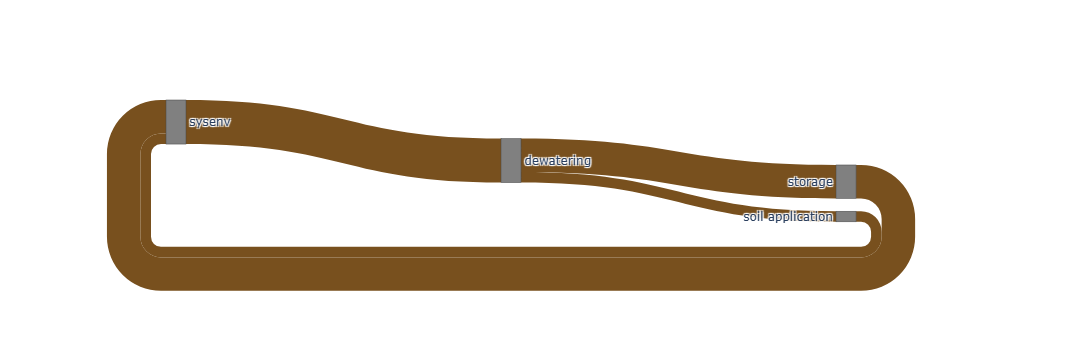

In [13]:
import flodym.export as fde

fig = fde.PlotlySankeyPlotter(mfa=mfa_project, exclude_processes=[], flow_color_dict = {"default":"rgb(120,80,30)"}).plot()
fig.show()

In [14]:
type(mfa_project.flows)

dict

In [15]:
print(mfa_project.flows)

{'sysenv => dewatering': Flow(dims=DimensionSet(dim_list=[Dimension(name='substance', letter='s', items=['Dry matter', 'Water'], dtype=<class 'str'>)]), values=array([100., 900.]), name='sysenv => dewatering', from_process=Process(name='sysenv', id=0), to_process=Process(name='dewatering', id=1)), 'dewatering => soil application': Flow(dims=DimensionSet(dim_list=[Dimension(name='substance', letter='s', items=['Dry matter', 'Water'], dtype=<class 'str'>)]), values=array([ 60., 180.]), name='dewatering => soil application', from_process=Process(name='dewatering', id=1), to_process=Process(name='soil application', id=2)), 'dewatering => storage': Flow(dims=DimensionSet(dim_list=[Dimension(name='substance', letter='s', items=['Dry matter', 'Water'], dtype=<class 'str'>)]), values=array([ 40., 720.]), name='dewatering => storage', from_process=Process(name='dewatering', id=1), to_process=Process(name='storage', id=3)), 'soil application => sysenv': Flow(dims=DimensionSet(dim_list=[Dimension

In [16]:
import pandas as pd

# Prepare a list to store the data
flow_data = []

# Iterate over each flow
for flow_name, flow_obj in mfa_project.flows.items():
    # Extract the substances and values
    substances = flow_obj.dims.dim_list[0].items
    values = flow_obj.values
    # Add a row for each substance
    for substance, value in zip(substances, values):
        flow_data.append({
            'flow_id': f"{flow_name}_{substance}",
            'flow_name': flow_name,
            'substance': substance,
            'value': value,
        })

# Convert to DataFrame
flows_df = pd.DataFrame(flow_data)

# Save to CSV
flows_df.to_csv('data/output_mfa.csv', index=False)
print("\nFlow values saved to 'data/output_mfa.csv'")


Flow values saved to 'data/output_mfa.csv'


# Brightway

## Project and Database creation

In [17]:
import bw2data as bd
import bw2io as bi

18:17:47+0100 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


In [ ]:
#bi.restore_project_directory("/srv/data/brightway2-project-ecoinvent-3.11-cutoff-bw25-backup.tar.gz", project_name="manure", overwrite_existing=True)

In [18]:
bd.projects

Brightway2 projects manager with 8 objects:
	Bicycle example
	USEEIO-1.1
	default
	ecoinvent-3.11-cutoff
	ecoinvent-3.11-cutoff-bw25
	ecoinvent-3.12-cutoff
	electric_vehicle_standalone
	manure
Use `projects.report()` to get a report on all projects.

In [19]:
bd.projects.set_current("manure") #switch to apply new current project
if 'manure' in bd.databases:
    del bd.databases['manure']
print(bd.databases)

Databases dictionary with 2 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff


In [20]:
if 'manure' not in bd.databases:
    db = bd.Database('manure')
    db.register()
bd.databases

Databases dictionary with 3 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	manure

In [21]:
db = bd.Database('manure')

## Nodes and Edges creation

### Nodes 

In [22]:
manure_production = db.new_node(
    code="manure_production",
    name='manure_production',
    location="DK",
    type=bd.labels.process_node_default,
)

manure_production.save()

manure = db.new_node(
    code="manure",
    name='manure',
    unit="kg",
    type=bd.labels.product_node_default,
)

manure.save()

dewatering = db.new_node(
    code="dewatering",
    name='dewatering',
    location='DK',
    type=bd.labels.process_node_default,
)
dewatering.save()

dewatering_product = db.new_node(
    code = "dewatering_product",
    name = 'dewatering_product',
    unit="kg",
    type=bd.labels.product_node_default,
)

dewatering_product.save()

soil_application = db.new_node(
    code="soil_application",
    name='soil_application',
    location='DK',
    type=bd.labels.process_node_default,
)
soil_application.save()

storage = db.new_node(
    code="storage",
    name='storage',
    location="DK",
    type=bd.labels.process_node_default,
)

storage.save()

soil_application_product = db.new_node(
    code = "soil_application_product",
    name = 'soil_application_product',
    unit="kg",
    type=bd.labels.product_node_default,
)

soil_application_product.save()

storage_product = db.new_node(
    code = "storage_product",
    name = 'storage_product',
    unit="kg",
    type=bd.labels.product_node_default,
)

storage_product.save()

manure_management = db.new_node(
    code="manure_management",
    name='manure_management',
    location="DK",
    type=bd.labels.process_node_default,
)

manure_management.save()

manure_managed = db.new_node(
    code = "manure_managed",
    name = 'manure_managed',
    unit="kg",
    type=bd.labels.product_node_default,
)

manure_managed.save()

In [23]:
# this is to search for the name
b_ei = bd.Database("ecoinvent-3.11-cutoff")

# Search for electricity activities in Switzerland (location code likely "CH")
for act in b_ei:
    if "electricity, medium" in act["name"].lower() and act.get("location", "").lower() == "dk":
        print(f"{act['name']} | {act.get('location', '')} | {act.get('code', '')}")
# 3. Get the ecoinvent electricity activity (Switzerland)
ei_elec = b_ei.get("6bcbd7fc891c8b3bf0dd96027c1f9b0e")
print(ei_elec)

market for electricity, medium voltage | DK | 6bcbd7fc891c8b3bf0dd96027c1f9b0e
electricity, medium voltage, residual mix | DK | 7274eddfd02218733d7349c975291423
electricity, from municipal waste incineration to generic market for electricity, medium voltage | DK | 6bc2f531645dc36e3bb7ee0a24941222
'market for electricity, medium voltage' (kilowatt hour, DK, None)


In [24]:
bio_ei = bd.Database("ecoinvent-3.11-biosphere")
for flow in bio_ei:
    if "methane, non-fossil" in flow["name"].lower():
        print(f"{flow['name']} | {flow.get('unit', '')} | {flow.get('code', '')}| {flow.get('categories', '')} ")
bio_ei_ch4 = bio_ei.get("da1157e2-7593-4dfd-80dd-a3449b37a4d8")
print(bio_ei_ch4)

Methane, non-fossil | kilogram | da1157e2-7593-4dfd-80dd-a3449b37a4d8| ('air',) 
Methane, non-fossil | kilogram | baf58fc9-573c-419c-8c16-831ac03203b9| ('air', 'urban air close to ground') 
Methane, non-fossil | kilogram | 57bdb443-d4a6-423d-8024-959b8261d02e| ('air', 'non-urban air or from high stacks') 
Methane, non-fossil | kilogram | 6c977009-5c4e-4901-a4c1-ab20389cb972| ('air', 'low population density, long-term') 
'Methane, non-fossil' (kilogram, None, ('air',))


### Edges

In [25]:
manure_production.new_edge(
    name="manure_1",
    amount=1,
    input=manure,
    type=bd.labels.production_edge_default,
    functional=True,
).save()

dewatering.new_edge(
    name="manure_2",
    amount = mfa_project.flows["sysenv => dewatering"].sum_over('s').values.item(),
    input=manure,
    type=bd.labels.consumption_edge_default,
).save()

dewatering.new_edge(
    name="dprod1",
    amount=1,
    input=dewatering_product,
    type=bd.labels.production_edge_default,
    functional=True,
).save()

dewatering.new_edge(
    name="ei_elec",
    amount=mfa_project.flows["sysenv => dewatering"].sum_over('s').values.item() * 1,
    input=ei_elec,
    type=bd.labels.consumption_edge_default,
).save()

storage.new_edge(
    name="liquid_1",
    amount=mfa_project.flows["dewatering => storage"].sum_over('s').values.item(),
    input=dewatering_product,
    type=bd.labels.consumption_edge_default,
).save()

storage.new_edge(
    name="methane",
    amount=mfa_project.flows["dewatering => storage"].sum_over('s').values.item()*0.5,
    input=bio_ei_ch4,
    type=bd.labels.biosphere_edge_default,
).save()

soil_application.new_edge(
    name="fibres_1",
    amount=mfa_project.flows["dewatering => soil application"].sum_over('s').values.item(),
    input=dewatering_product,
    type=bd.labels.consumption_edge_default,
).save()

soil_application.new_edge(
    name="fibres_2",
    amount=1,
    input=soil_application_product,
    type=bd.labels.production_edge_default,
    functional=True,
).save()

storage.new_edge(
    name="liquid_2",
    amount=1,
    input=storage_product,
    type=bd.labels.production_edge_default,
    functional=True,
).save()

manure_management.new_edge(
    name="soil_prod",
    amount=mfa_project.flows["dewatering => soil application"].sum_over('s').values.item(),
    input=soil_application_product,
    type=bd.labels.consumption_edge_default,
).save()

manure_management.new_edge(
    name="storage_prod",
    amount=mfa_project.flows["dewatering => storage"].sum_over('s').values.item(),
    input=storage_product,
    type=bd.labels.consumption_edge_default,
).save()

manure_management.new_edge(
    name="managed_manure",
    amount=mfa_project.flows["dewatering => storage"].sum_over('s').values.item()+
        mfa_project.flows["dewatering => soil application"].sum_over('s').values.item(),
    input=manure_managed,
    type=bd.labels.production_edge_default,
    functional=True,
).save()

In [26]:
for act in bd.Database("manure"):
    print()
    print(act)
    for e in act.edges():
        print(e)


'dewatering_product' (kg, GLO, None)

'soil_application' (None, DK, None)
Exchange: 240.0 kg 'dewatering_product' (kg, GLO, None) to 'soil_application' (None, DK, None)>
Exchange: 1 kg 'soil_application_product' (kg, GLO, None) to 'soil_application' (None, DK, None)>

'manure_managed' (kg, GLO, None)

'storage_product' (kg, GLO, None)

'dewatering' (None, DK, None)
Exchange: 1000.0 kg 'manure' (kg, GLO, None) to 'dewatering' (None, DK, None)>
Exchange: 1 kg 'dewatering_product' (kg, GLO, None) to 'dewatering' (None, DK, None)>
Exchange: 1000.0 kilowatt hour 'market for electricity, medium voltage' (kilowatt hour, DK, None) to 'dewatering' (None, DK, None)>

'manure' (kg, GLO, None)

'manure_management' (None, DK, None)
Exchange: 240.0 kg 'soil_application_product' (kg, GLO, None) to 'manure_management' (None, DK, None)>
Exchange: 760.0 kg 'storage_product' (kg, GLO, None) to 'manure_management' (None, DK, None)>
Exchange: 1000.0 kg 'manure_managed' (kg, GLO, None) to 'manure_managemen

In [43]:
def print_database_edges(database_name, verbose=True):
    
    db = bd.Database(database_name)
    all_edges = []

    for act in db:
        edge_types = [e['type'] for e in act.edges()]
        if verbose:
            print(f"\n=== Activity: {act['name']} ===")

        for e in act.edges():
            # Try to get linked dataset info (name + source database)
            try:
                input_ds = bd.get_activity(e['input'])
                input_name = input_ds.get('name', str(e['input'][1]))
                input_db = input_ds.key[0]
            except Exception:
                input_name = str(e['input'][1])
                input_db = e['input'][0] if isinstance(e['input'], tuple) else "unknown"

            amount = e['amount']
            edge_type = e['type']

            if verbose:
                print(f"  {edge_type:15s} | from db: {input_db:25s} | input: {input_name} | amount: {amount}")

    return all_edges

In [44]:
print_database_edges("manure")


=== Activity: manure_managed ===

=== Activity: manure_production ===
  production      | from db: manure                    | input: manure | amount: 1

=== Activity: soil_application_product ===

=== Activity: storage_product ===

=== Activity: storage ===
  technosphere    | from db: manure                    | input: dewatering_product | amount: 760.0
  biosphere       | from db: ecoinvent-3.11-biosphere  | input: Methane, non-fossil | amount: 380.0
  production      | from db: manure                    | input: storage_product | amount: 1

=== Activity: dewatering ===
  technosphere    | from db: manure                    | input: manure | amount: 1000.0
  production      | from db: manure                    | input: dewatering_product | amount: 1
  technosphere    | from db: ecoinvent-3.11-cutoff     | input: market for electricity, medium voltage | amount: 1000.0

=== Activity: manure ===

=== Activity: manure_management ===
  technosphere    | from db: manure                  

[]

### Checking of matrix nodes and processes and creation of graphs

In [ ]:
print({node['name'] for node in db if node['type'] == 'process'})
print({node['name'] for node in db if node['type'] == 'product'})

In [84]:
from IPython.display import Markdown

def flowchart_dave_dev(database_name):
    db = bd.Database(database_name)

    output_mermaid = "flowchart LR"

    for node in db:
        process_name = node['name'].replace(" ", "_")
        # --- Production exchanges ---
        for edge in node.production():
            input_ds = bd.get_activity(edge['input'])
            if input_ds['database'] == database_name:
                product_name = input_ds['name'].replace(" ", "_")
            else:
                product_name = input_ds['name'].replace(" ", "_") +("/")+ input_ds['database'].replace(" ", "_")
            output_mermaid += f"\n\t{process_name} --> {product_name}{{{product_name}}}"
        # --- Technosphere exchanges ---
        for edge in node.technosphere():
            if edge["type"] != "production":
                input_ds = bd.get_activity(edge['input'])
            if input_ds['database'] == database_name:
                product_name = input_ds['name'].replace(" ", "_")
            else:
                product_name = input_ds['name'].replace(" ", "_") +("/")+ input_ds['database'].replace(" ", "_")
            output_mermaid += f"\n\t{product_name}{{{product_name}}} --> {process_name}"
        # --- Biosphere exchanges ---
        for edge in node.biosphere():
            input_ds = bd.get_activity(edge['input'])
            if input_ds['database'] == database_name:
                flow_name = input_ds['name'].replace(" ", "_")
            else:
                flow_name = input_ds['name'].replace(" ", "_") +("/")+ input_ds['database'].replace(" ", "_")
            output_mermaid += f"\n\t{process_name} --> {flow_name}{{{flow_name}}}"

    return Markdown(f"```mermaid\n{output_mermaid}\n```")

In [85]:
flowchart_dave_dev("manure")

```mermaid
flowchart LR
	dewatering --> dewatering_product{dewatering_product}
	manure{manure} --> dewatering
	market_for_electricity,_medium_voltage/ecoinvent-3.11-cutoff{market_for_electricity,_medium_voltage/ecoinvent-3.11-cutoff} --> dewatering
	soil_application --> soil_application_product{soil_application_product}
	dewatering_product{dewatering_product} --> soil_application
	storage --> storage_product{storage_product}
	dewatering_product{dewatering_product} --> storage
	storage --> Methane,_non-fossil/ecoinvent-3.11-biosphere{Methane,_non-fossil/ecoinvent-3.11-biosphere}
	manure_production --> manure{manure}
	manure_management --> manure_managed{manure_managed}
	soil_application_product{soil_application_product} --> manure_management
	storage_product{storage_product} --> manure_management
```

### LCI and LCIA

#### Selecting the method of CML

In [ ]:
my_methods = [
    m for m in bd.methods 
    if "CML v4.8 2016" in m and m[0].startswith("ecoinvent")
]

# Quick check
print(f"Found {len(my_methods)} CML methods:")
for m in my_methods:
    print(" -", m)

#### Caculating the impact

In [ ]:
import bw2calc as bc
import stats_arrays as sa

In [ ]:
results = {}

for method in my_methods:
    lca = bc.LCA({manure_managed: 1}, method)
    lca.lci()
    lca.lcia()
    results[method] = lca.score

# Optional: convert to pandas DataFrame for a nice summary
import pandas as pd
df = pd.DataFrame.from_dict(results, orient='index', columns=['Score'])
df.reset_index(inplace=True)
df.columns = ['Method', 'Score']
print(df)